# Notebook to forecast quantiles for the DAX

# Imports

In [107]:
import pandas as pd
import numpy as np
import statsmodels as sm
import yfinance as yf
from datetime import datetime
import requests
import json
import sys
import math

from prophet import Prophet

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

import arch
from arch import arch_model

#from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
#from darts.utils.likelihood_models import GaussianLikelihood
#from darts.timeseries import TimeSeries

pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', sys.maxsize)

# Functions

In [3]:
def quantile_loss(y_true, y_pred, quantile):
    
    if y_true > y_pred:
        loss = quantile * (y_true - y_pred)
    else:
        loss = (1 - quantile) * (y_pred - y_true)
    return loss


In [4]:
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

In [119]:
def create_submission_table():
    forecast_date = [str(datetime.now().date())] * 16
    target = ["DAX"] * 5 + ["energy"] * 6 + ["wind"] * 5
    horizon = ['1 day', '2 day', '5 day', '6 day', '7 day', '36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour', '36 hour', '48 hour', '60 hour', '72 hour', '84 hour']
    
    return pd.DataFrame({"forecast_date": forecast_date, "target": target, "horizon": horizon, "q0.025": [np.nan]*16, "q0.25": [np.nan]*16, "q0.5": [np.nan]*16, "q0.75": [np.nan]*16, "q0.975": [np.nan]*16})

In [6]:
def get_dax_data():
    msft = yf.Ticker("^GDAXI")
    hist = msft.history(period="max")
    data = hist[["Close"]]
    data = data.reset_index().rename(columns={"Date": "date_time"})
    data.set_index("date_time", inplace = True)
    data["data"] = compute_return(data.Close.values)
    data = data.dropna()
    data = data.drop(columns = "Close")
    #data = data.data.values
    
    return data

In [7]:
# Get energydata from csv
"""def get_energy_data():
    data = pd.read_csv("energy_data.csv", sep=";")
    data = data[data.columns[:3]]
    data = data.rename(columns={"Gesamt (Netzlast)[MWh]": "data"})
    data = data[data["data"] != "-"]
    data["date_time"] = pd.to_datetime(data['Datum'] + ' ' + data['Uhrzeit'], format = '%d.%m.%Y %H:%M')
    data = data.drop(columns = ["Datum", "Uhrzeit"])
    data = data.astype({"data": float})
    data.set_index("date_time", inplace=True)
    data = data.resample("1h", label = "left").sum()
    #data = data.data.values
    
    return data"""

In [258]:
def get_energy_data(): 
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    timestamps = list(response.json()["timestamps"])

    energydata = pd.DataFrame(columns=["date_time", "data"])
    for stamp in timestamps[157:]:
        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]
        for i in range(len(rawdata)):
            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")
        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=["date_time", "data"])])
    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    energydata.set_index("date_time", inplace=True)
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [158]:
def create_submission_file(submission):
    submission.to_csv(datetime.now().strftime("%Y%m%d") + "_GreyWorm.csv", index = False)
    print("Submission file created")

# Load Data

In [176]:
daxdata = get_dax_data()
energydata = get_energy_data()

# Modeling

## DAX

### Darts

In [175]:
prob_model = ExponentialSmoothing()

In [176]:
prob_model = prob_model.fit(TimeSeries.from_values(rets))

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [177]:
pred = prob_model.predict(5, num_samples=100)

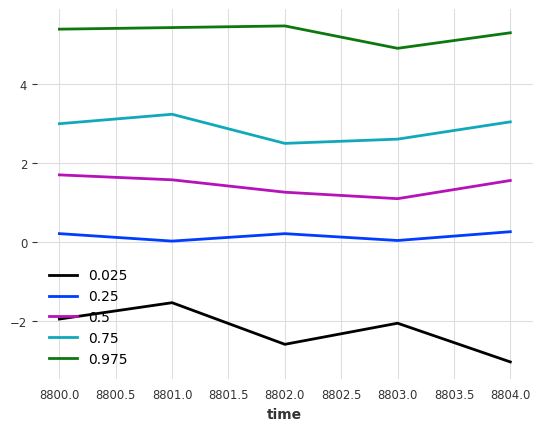

In [178]:
pred.quantile_timeseries(0.025).plot(label = "0.025")
pred.quantile_timeseries(0.25).plot(label = "0.25")
pred.quantile_timeseries(0.5).plot(label = "0.5")
pred.quantile_timeseries(0.75).plot(label = "0.75")
pred.quantile_timeseries(0.975).plot(label = "0.975")

In [179]:
sub = pd.DataFrame({"q0.025": pred.quantile_timeseries(0.025).pd_series(),
                   "q0.25": pred.quantile_timeseries(0.25).pd_series(),
                   "q0.5": pred.quantile_timeseries(0.5).pd_series(),
                   "q0.75": pred.quantile_timeseries(0.75).pd_series(),
                   "q0.975": pred.quantile_timeseries(0.975).pd_series()})

In [180]:
sub = sub.reset_index().drop(columns = "time")

In [181]:
sub["forecast_date"] = "2022-10-26"
sub["target"] = "DAX"
sub["horizon"] = ["1 day", "2 day", "5 day", "6 day", "7 day"]

In [182]:
sub = sub[["forecast_date", "target", "horizon", "q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]]

In [183]:
nans = pd.Series(["2022-10-26", "energy", None, None, None, None, None, None], index = sub.columns)
for i in range(6):
    sub = sub.append(nans, ignore_index = True)

/var/folders/g6/cmh9kt9x26db790xkfg9b3y40000gn/T/ipykernel_54084/1045233296.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub.append(nans, ignore_index = True)


In [184]:
nans = pd.Series(["2022-10-26", "wind", None, None, None, None, None, None], index = sub.columns)
for i in range(5):
    sub = sub.append(nans, ignore_index = True)

/var/folders/g6/cmh9kt9x26db790xkfg9b3y40000gn/T/ipykernel_54084/4031082620.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub.append(nans, ignore_index = True)


In [190]:
sub.horizon.iloc[5:11] = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

/var/folders/g6/cmh9kt9x26db790xkfg9b3y40000gn/T/ipykernel_54084/2573154423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.horizon.iloc[5:11] = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']


In [194]:
sub.horizon.iloc[11:16] = ['36 hour', '48 hour', '60 hour', '72 hour', '84 hour']

/var/folders/g6/cmh9kt9x26db790xkfg9b3y40000gn/T/ipykernel_54084/2441354173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.horizon.iloc[11:16] = ['36 hour', '48 hour', '60 hour', '72 hour', '84 hour']


In [195]:
sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2022-10-26,DAX,1 day,-1.944848,0.216140,1.702465,2.997505,5.389528
1,2022-10-26,DAX,2 day,-1.531212,0.027386,1.577861,3.236119,5.429700
2,2022-10-26,DAX,5 day,-2.584560,0.215435,1.264385,2.499556,5.471471
3,2022-10-26,DAX,6 day,-2.050316,0.042469,1.100540,2.606875,4.904985
4,2022-10-26,DAX,7 day,-3.029857,0.264885,1.560649,3.044176,5.297935
5,2022-10-26,energy,36 hour,NaN,NaN,NaN,NaN,NaN
6,2022-10-26,energy,40 hour,NaN,NaN,NaN,NaN,NaN
7,2022-10-26,energy,44 hour,NaN,NaN,NaN,NaN,NaN
8,2022-10-26,energy,60 hour,NaN,NaN,NaN,NaN,NaN
9,2022-10-26,energy,64 hour,NaN,NaN,NaN,NaN,NaN


In [196]:
sub.to_csv("20221026_GreyWorm.csv", index = False)

### Prophet

In [9]:
daxdata = daxdata.reset_index()
daxdata = daxdata.rename(columns={"date_time": "ds", "data": "y"})
daxdata["ds"] = daxdata['ds'].dt.date
daxdata["ds"] = pd.to_datetime(daxdata.ds)

In [12]:
model = Prophet()
model.fit(daxdata)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [13]:
forecast = model.make_future_dataframe(periods=5)

In [14]:
forecast = model.predict(forecast)

In [16]:
forecast = pd.merge(forecast, daxdata, on="ds", how="left")

In [24]:
forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
8800,2022-10-27,-0.816971,-1.707498,1.793633,-0.816971,-0.816971,0.859546,0.859546,0.859546,0.801165,0.801165,0.801165,0.058381,0.058381,0.058381,0.0,0.0,0.0,0.042575,0.116794
8801,2022-10-28,-0.816971,-1.778035,1.794708,-0.816971,-0.816971,0.880046,0.880046,0.880046,0.827649,0.827649,0.827649,0.052397,0.052397,0.052397,0.0,0.0,0.0,0.063075,0.242677
8802,2022-10-31,-0.816973,-1.721708,1.868690,-0.816973,-0.816973,0.903495,0.903495,0.903495,0.863445,0.863445,0.863445,0.040051,0.040051,0.040051,0.0,0.0,0.0,0.086522,0.078576
8803,2022-11-01,-0.816974,-1.692930,1.798402,-0.816974,-0.816974,0.910618,0.910618,0.910618,0.872337,0.872337,0.872337,0.038281,0.038281,0.038281,0.0,0.0,0.0,0.093644,0.639281
8804,2022-11-02,-0.816974,-1.793985,1.765202,-0.816974,-0.816974,0.866090,0.866090,0.866090,0.828272,0.828272,0.828272,0.037817,0.037817,0.037817,0.0,0.0,0.0,0.049115,-0.250260
8805,2022-11-03,-0.816975,-1.732707,1.820980,-0.816975,-0.816975,0.839838,0.839838,0.839838,0.801165,0.801165,0.801165,0.038674,0.038674,0.038674,0.0,0.0,0.0,0.022863,NaN
8806,2022-11-04,-0.816975,-1.680030,1.851443,-0.816975,-0.816975,0.868465,0.868465,0.868465,0.827649,0.827649,0.827649,0.040816,0.040816,0.040816,0.0,0.0,0.0,0.051490,NaN
8807,2022-11-05,-0.816976,-4.733083,-1.054194,-0.816976,-0.816976,-2.052265,-2.052265,-2.052265,-2.096433,-2.096433,-2.096433,0.044168,0.044168,0.044168,0.0,0.0,0.0,-2.869241,NaN
8808,2022-11-06,-0.816977,-4.643498,-1.117687,-0.816977,-0.816977,-2.047825,-2.047825,-2.047825,-2.096434,-2.096434,-2.096434,0.048609,0.048609,0.048609,0.0,0.0,0.0,-2.864802,NaN
8809,2022-11-07,-0.816977,-1.776479,1.887420,-0.816977,-0.816977,0.917427,0.917427,0.917427,0.863445,0.863445,0.863445,0.053982,0.053982,0.053982,0.0,0.0,0.0,0.100450,NaN


<AxesSubplot: >

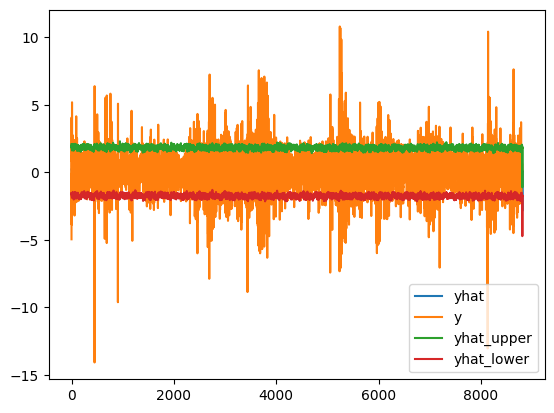

In [23]:
forecast[["yhat", "y", "yhat_upper", "yhat_lower"]].plot()

### ARMA

In [34]:
daxdata.head()

,data
date_time,
1988-01-04 00:00:00+01:00,-4.966154
1988-01-05 00:00:00+01:00,4.057731
1988-01-06 00:00:00+01:00,0.989967
1988-01-07 00:00:00+01:00,0.837426
1988-01-08 00:00:00+01:00,1.197370


In [70]:
daxdata.data = daxdata.data**2

<AxesSubplot: xlabel='date_time'>

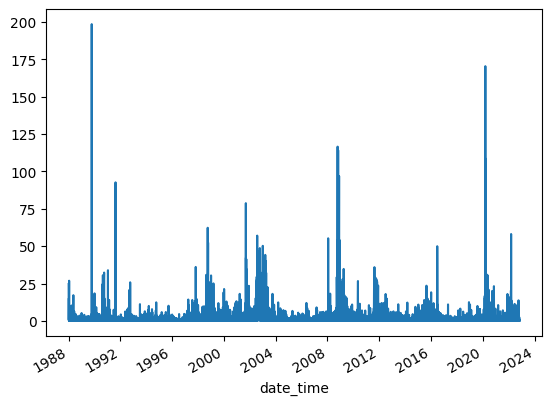

In [71]:
daxdata.data.plot()


/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


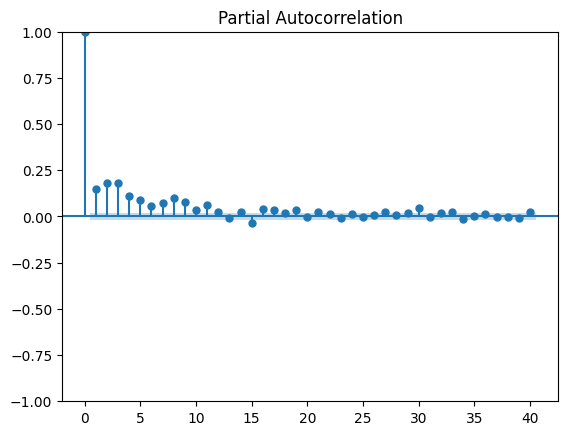

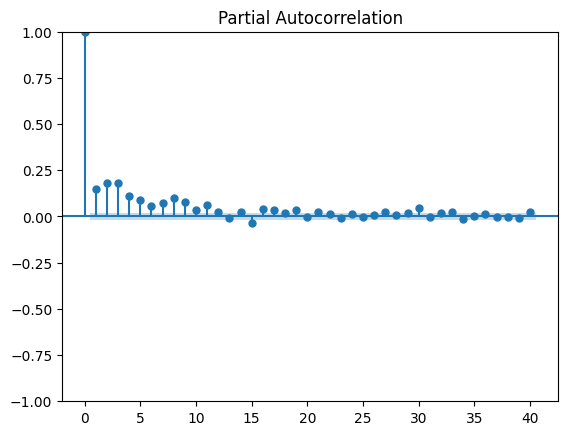

In [38]:
plot_pacf(daxdata.data**2)

In [39]:
model = SARIMAX(daxdata['data']**2, order=(3,0,3)).fit()
print(model.summary())

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11031D+00    |proj g|=  3.33404D-02

At iterate    5    f=  3.10836D+00    |proj g|=  3.45692D-03

At iterate   10    f=  3.10797D+00    |proj g|=  8.01006D-04

At iterate   15    f=  3.10795D+00    |proj g|=  2.10936D-04

At iterate   20    f=  3.10786D+00    |proj g|=  4.83190D-03

At iterate   25    f=  3.10765D+00    |proj g|=  1.39216D-02

At iterate   30    f=  3.10748D+00    |proj g|=  1.29204D-03

At iterate   35    f=  3.10743D+00    |proj g|=  9.10992D-04

At iterate   40    f=  3.10742D+00    |proj g|=  1.85914D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [62]:
arcoefs = [1] + list(model.params)[:-1][0:3] #0:p
macoefs = [1] + list(model.params)[:-1][3:3+3] #p:p+q

In [63]:
macoefs

[1, 0.36285135464551854, -0.24697720274812993, -0.8072258385211268]

In [64]:
armadata = ArmaProcess(arcoefs, macoefs).generate_sample(nsample=1000)

<AxesSubplot: >

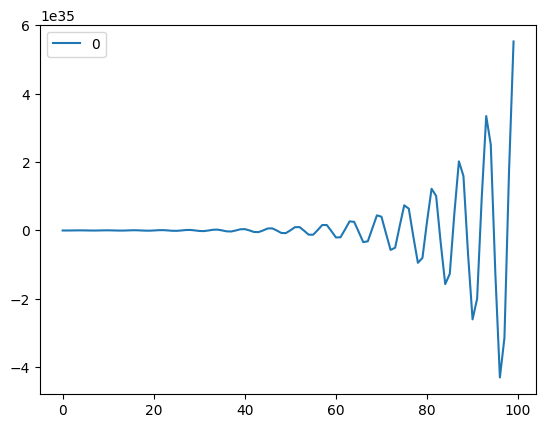

In [67]:
pd.DataFrame(armadata[-100:]).plot()

### GARCH

In [ ]:
daxdata

In [87]:
model = arch_model(daxdata, mean='Zero', vol='GARCH', p=15, q=15)

In [88]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     33,   Neg. LLF: 21940.665620481683
Iteration:      2,   Func. Count:     69,   Neg. LLF: 339206.7534041328
Iteration:      3,   Func. Count:    102,   Neg. LLF: 17451.236967696157
Iteration:      4,   Func. Count:    135,   Neg. LLF: 17624.76789595329
Iteration:      5,   Func. Count:    169,   Neg. LLF: 19669.991086009246
Iteration:      6,   Func. Count:    202,   Neg. LLF: 15047.983462340699
Iteration:      7,   Func. Count:    235,   Neg. LLF: 15460.685075028658
Iteration:      8,   Func. Count:    268,   Neg. LLF: 27033.959307122623
Iteration:      9,   Func. Count:    301,   Neg. LLF: 16787.101314663614
Iteration:     10,   Func. Count:    334,   Neg. LLF: 20163.706879567828
Iteration:     11,   Func. Count:    368,   Neg. LLF: 15688.30378334319
Iteration:     12,   Func. Count:    402,   Neg. LLF: 16191.6411775923
Iteration:     13,   Func. Count:    436,   Neg. LLF: 14486.354629866859
Iteration:     14,   Func. Count:    469,   Neg. LLF: 15

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [93]:
ret2 = daxdata.data**2

<AxesSubplot: xlabel='date_time'>

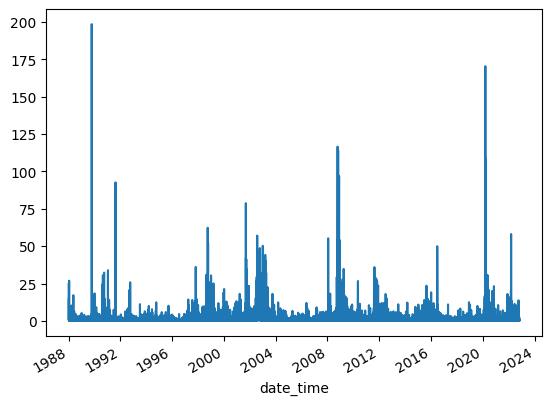

In [95]:
ret2.plot()

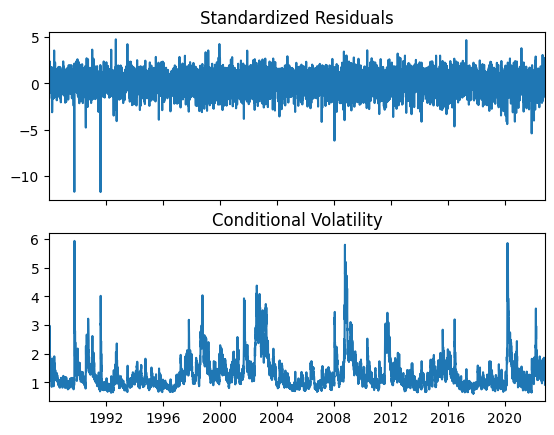

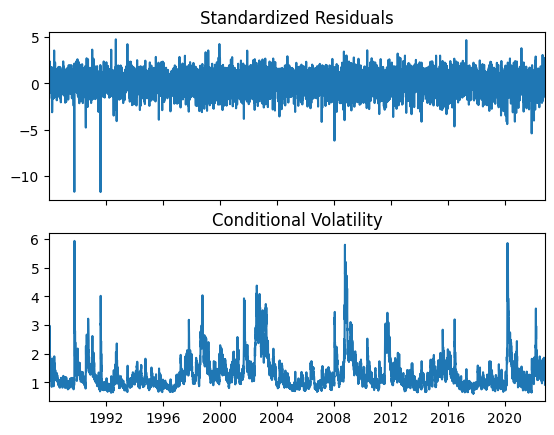

In [106]:
model_fit.plot()

In [105]:
yhat = model_fit.forecast(horizon=5)
yhat.variance.tail()

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


,h.1,h.2,h.3,h.4,h.5
date_time,,,,,
2022-10-27 00:00:00+02:00,NaN,NaN,NaN,NaN,NaN
2022-10-28 00:00:00+02:00,NaN,NaN,NaN,NaN,NaN
2022-10-31 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN
2022-11-01 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN
2022-11-02 00:00:00+01:00,1.000256,0.897863,0.970461,0.947827,0.974007


In [115]:
h1sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.1"].iloc[-1]), size=1000)
h2sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.2"].iloc[-1]), size=1000)
h3sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.3"].iloc[-1]), size=1000)
h4sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.4"].iloc[-1]), size=1000)
h5sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.5"].iloc[-1]), size=1000)

In [112]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

In [142]:
h1quantiles = np.quantile(h1sample, quantiles)
h2quantiles = np.quantile(h2sample, quantiles)
h3quantiles = np.quantile(h3sample, quantiles)
h4quantiles = np.quantile(h4sample, quantiles)
h5quantiles = np.quantile(h5sample, quantiles)
daxquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles]

## Energy

In [259]:
energydata = get_energy_data()

In [178]:
energydata = energydata.loc[energydata.data != 0]

<AxesSubplot: xlabel='date_time'>

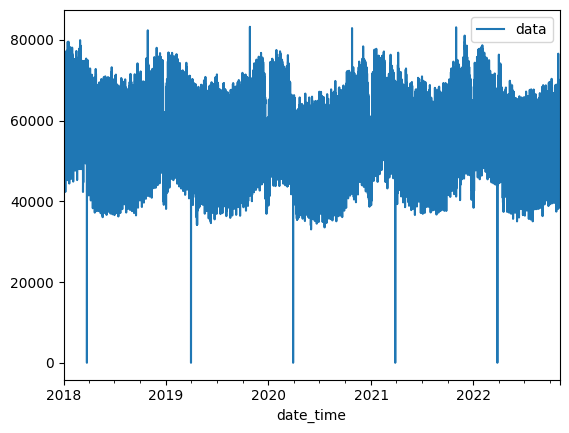

In [260]:
energydata.plot()

In [275]:
enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

<AxesSubplot: xlabel='date_time'>

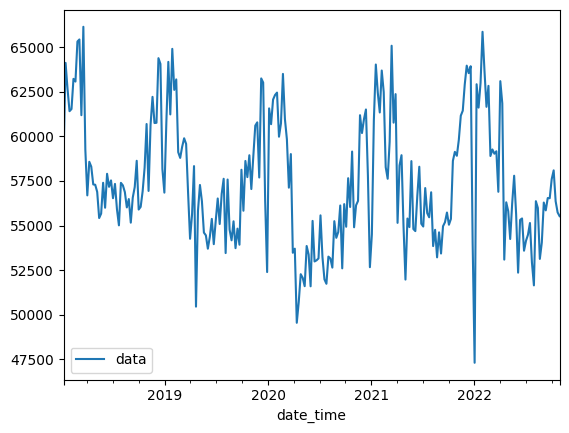

In [283]:
ens12.plot()

<AxesSubplot: xlabel='date_time'>

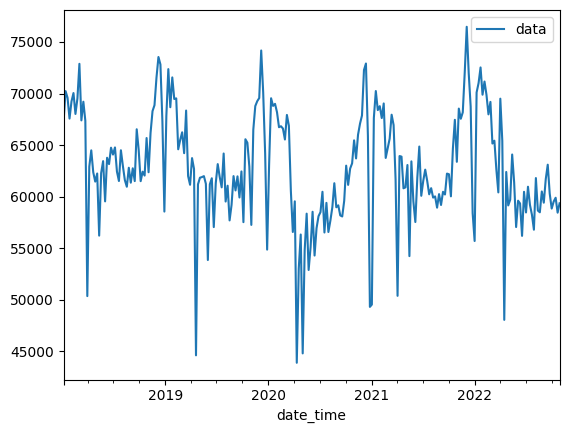

In [281]:
ens16.plot()

<AxesSubplot: xlabel='date_time'>

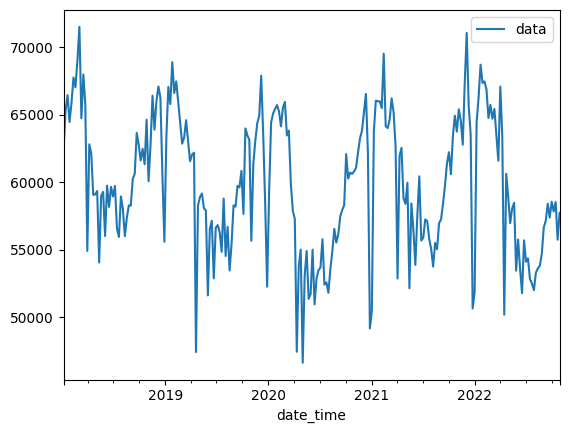

In [282]:
enf20.plot()

# Submission Creation

In [167]:
submission = create_submission_table()

In [168]:
for i in range(5):
    submission.loc[i, ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]] = daxquantiles[i]

In [165]:
for i in range(6):
    submission.loc[5+i, ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]] = energyquantiles[i]

In [169]:
submission

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2022-11-02,DAX,1 day,-1.946219,-0.666303,0.047297,0.697642,2.024324
1,2022-11-02,DAX,2 day,-1.754379,-0.602774,0.083571,0.646914,1.791037
2,2022-11-02,DAX,5 day,-1.961899,-0.634639,-0.020732,0.590524,1.746128
3,2022-11-02,DAX,6 day,-1.718626,-0.674061,-0.021146,0.664456,1.853741
4,2022-11-02,DAX,7 day,-1.843037,-0.674998,-0.018268,0.684109,1.934115
5,2022-11-02,energy,36 hour,NaN,NaN,NaN,NaN,NaN
6,2022-11-02,energy,40 hour,NaN,NaN,NaN,NaN,NaN
7,2022-11-02,energy,44 hour,NaN,NaN,NaN,NaN,NaN
8,2022-11-02,energy,60 hour,NaN,NaN,NaN,NaN,NaN
9,2022-11-02,energy,64 hour,NaN,NaN,NaN,NaN,NaN


In [159]:
create_submission_file(submission)

Submission file created


# Check

In [137]:
! python check.py -p 20221026_GreyWorm.csv

{'path': '20221026_GreyWorm.csv', 'exclude_weather': None}
Loading file... 20221026_GreyWorm.csv
File loaded! Start Checking...
---------------------------
Checking the Columns...
Checking type of columns...
----WARNING: Some elements in q0.025 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.25 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.5 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.75 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.975 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

Checking if the Dates make sense...
Checking targets...
Checking quantiles...
Assume that -- energy -- is your NaN-target. Please DOUBLECHECK if this is correct.
Your dataframe contains more NaNs than entri